In [1]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
from autoencoder import AE

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # cuda for gpus, cpu otherwise
torch.set_default_device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [3]:
BATCH_SIZE = 64
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-5
ENCODE_DIM = 4096 # increase this with more storage?
HIDDEN_LAYER = 2*ENCODE_DIM
EPOCHS = 15

In [4]:
print(f'Compression amount: {ENCODE_DIM / (299*299*3)}')

Compression amount: 0.01527201410871616


In [5]:
PATH = '/groups/francescavitali/eb2/subImages2/H&E'

tensor_transform = transforms.Compose([
        transforms.Grayscale(),
        transforms.ToTensor()
    ])

dataset = datasets.ImageFolder(PATH, 
                              transform = tensor_transform) #loads the images

train_set, test_set = torch.utils.data.random_split(dataset,
                                                   [194,10],
                                                   generator=torch.Generator(device=device))

loader = torch.utils.data.DataLoader(dataset = train_set,
                                    batch_size = BATCH_SIZE,
                                    shuffle = True,
                                    generator=torch.Generator(device=device))

In [6]:
# checks the range of the pixels
dataiter = iter(loader)
images, labels = next(dataiter)
print(f'Minimum value: ', end='')
print(torch.min(images))
print(f'Maximum value: ', end='')
print(torch.max(images))

Minimum value: tensor(0.0431)
Maximum value: tensor(1.)


In [7]:
model = AE(299*299, HIDDEN_LAYER, ENCODE_DIM).to(device) # 299x299 and RGB images

loss_function = torch.nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE, weight_decay = WEIGHT_DECAY)

In [8]:
print(model)

AE(
  (encoder): Sequential(
    (0): Linear(in_features=89401, out_features=4096, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=4096, out_features=89401, bias=True)
    (1): Sigmoid()
  )
)


In [9]:
#os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
outputs = []
for epoch in range(EPOCHS):
    
    count = 0
    loss_total = 0
    
    model.train()
    for (image, _) in loader:
        image = image.to(device)
        image = image.flatten(start_dim=1) # ignore the batch_size
        
        recon = model(image)
        loss = loss_function(recon, image)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
                
        # UI
        sys.stdout.write('\r')
        loss_total += loss.item()
        sys.stdout.write("Epoch: {} [{:{}}] {:.1f}% | Loss: {}".format(epoch+1, "="*count, 
                                                                       len(loader)-1, 
                                                                       (100/(len(loader)-1)*count), 
                                                                       loss_total/(count+1)))
        sys.stdout.flush()
        
        count += 1
    outputs.append((epoch, image[1], recon[1]))

    print(f'\nEpoch: {epoch + 1} | Loss: {(loss_total)/len(loader):.4f}', end='\n'*2)

Epoch: 1 [===] 100.0% | Loss: 64.10802580416203
Epoch: 1 | Loss: 64.1080

Epoch: 2 [===] 100.0% | Loss: 8.481758832931519
Epoch: 2 | Loss: 8.4818

Epoch: 3 [===] 100.0% | Loss: 8.514396667480469
Epoch: 3 | Loss: 8.5144

Epoch: 4 [===] 100.0% | Loss: 7.838801860809326
Epoch: 4 | Loss: 7.8388

Epoch: 5 [===] 100.0% | Loss: 8.786200523376465
Epoch: 5 | Loss: 8.7862

Epoch: 6 [===] 100.0% | Loss: 8.060063481330872
Epoch: 6 | Loss: 8.0601

Epoch: 7 [===] 100.0% | Loss: 8.193282961845398
Epoch: 7 | Loss: 8.1933

Epoch: 8 [===] 100.0% | Loss: 8.915006279945374
Epoch: 8 | Loss: 8.9150

Epoch: 9 [===] 100.0% | Loss: 8.238327860832214
Epoch: 9 | Loss: 8.2383

Epoch: 10 [===] 100.0% | Loss: 7.699507355690002
Epoch: 10 | Loss: 7.6995

Epoch: 11 [===] 100.0% | Loss: 9.266819715499878
Epoch: 11 | Loss: 9.2668

Epoch: 12 [===] 100.0% | Loss: 8.055940985679626
Epoch: 12 | Loss: 8.0559

Epoch: 13 [===] 100.0% | Loss: 8.793079853057861
Epoch: 13 | Loss: 8.7931

Epoch: 14 [===] 100.0% | Loss: 8.944655418

15


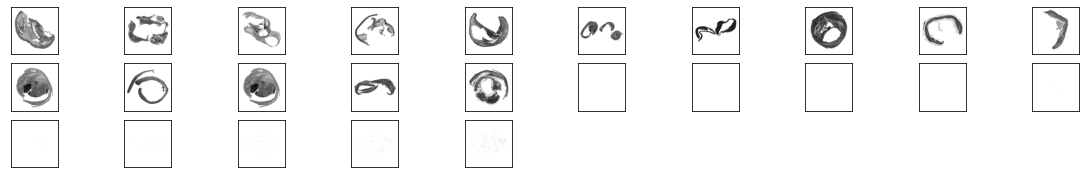

In [10]:
amt = 10
plt.figure(figsize=(20,4))
print(len(outputs))

for i in range(len(outputs)):
    img = outputs[i][1]
    recon = outputs[i][2]
        
    ax = plt.subplot(4, amt, i+1)
    img = torch.unflatten(img, 0, (299, 299)).detach().cpu().numpy()
    #plt.imshow(np.transpose(img, (1,2,0))) # changes to rgb
    plt.gray()

    plt.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(4,amt, i+1+amt)
    

    
    recon = torch.unflatten(recon, 0, (299,299)).detach().cpu().numpy()
    plt.imshow(recon)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    

In [9]:
torch.save(model.state_dict(), './models/model.pth') # save in case crashes

In [11]:
encoder = model.encoder
decoder = model.decoder

In [12]:
auto_encoder_output = []
encoded_imgs_arr = []
decoded_imgs_arr = []
img_set = test_set # test_set

for x in range(len(img_set)):
    with torch.no_grad():
        inp = img_set.__getitem__(x)[0].to(device).flatten()
        
        encoded_imgs = encoder(inp)
        encoded_imgs_arr.append(encoded_imgs)
        
        decoded_imgs = decoder(encoded_imgs)
        decoded_imgs_arr.append((inp, decoded_imgs))
        
        auto_encoder_output.append((inp, model(inp)))

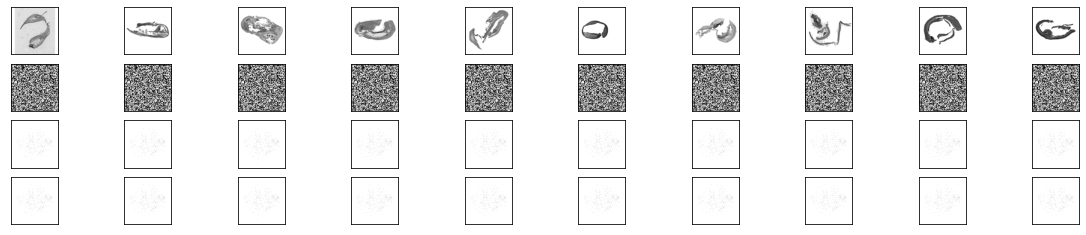

In [13]:
amt = 10
plt.figure(figsize=(20,4))


for k in range(amt):
    ax = plt.subplot(4, amt, k+1)
    plt.gray()
    
    img = decoded_imgs_arr[k][0]
    img = torch.unflatten(img, 0, (299, 299)).detach().cpu().numpy()
    plt.imshow(img) # changes to rgb
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(4,amt, k+1+amt)
    plt.gray()

    img = encoded_imgs_arr[k].detach().cpu().numpy()
    img = img.reshape(-1,64,64)
    plt.imshow(img[0])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    
    ax = plt.subplot(4,amt, k+1+2*amt)
    recon = decoded_imgs_arr[k][1]
    recon = torch.unflatten(recon, 0, (299, 299)).detach().cpu().numpy()
    plt.imshow(recon)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(4,amt, k+1+3*amt)

    recon = auto_encoder_output[k][1]
    recon = torch.unflatten(recon, 0, (299,299)).detach().cpu().numpy()
    plt.imshow(recon)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [ ]:
# need to try CNN autoencoder next